In [269]:
import numpy as np
import matplotlib.pyplot as plt

In [319]:
# Initialise X, Y, weights and bias
X = np.random.rand(20, 2)
Y = np.random.rand(20, 1)
B = np.random.rand(1, 1)
W = np.random.rand(1, X.shape[1]).T

In [176]:
# Activation functions
# Linear
def linear(z_input):
    return z_input

# Sigmoid
def sigmoid(z_input):
    return 1/(1+np.exp(-z_input))

# ReLU
def relu(z_input):
    return np.maximum(0, z_input)

# leaky ReLU
def leaky_relu(z_input, alpha = 0.01):
    return np.maximum(alpha*z_input, z_input)

# tanh
def tanh(z_input):
    return np.tanh(z_input)

In [4]:
# A loss function
def loss(y_hat, y):
    return ((y_hat - y)**2)

In [5]:
# Function to calculate the value of the derivative of a function at a given value
def der_fun(fun, x):
    h = 1e-5
    return (fun(x+h)-fun(x-h))/(2*h)

In [6]:
# A fancy loading bar function
def show_progress(i, iters, bar_len = 50):
    p = int(bar_len*((i+1)/(iters)))
    p_bar = '-'*p+'>'+'_'*(bar_len-(p))
    perc = round(((i+1)/(iters))*100, 2)
    print(f'{p_bar} {perc}%', end = '\r')

In [598]:
# A single neuron
class Neuron:
    
    # Initialise as a stateless, empty neuron with an activation function
    def __init__(self, act_func,
                 learn_rate = 0.01,
                 gradient_memory = 1,
                 gradient_clip = 1,
                 init_weight_scale = (-0.5, 0.5)):
        self.X = None
        self.W = None
        self.B = None
        self.nextgrad = None
        self.act_func = act_func
        self.learn_rate = learn_rate
        self.gradient_memory = gradient_memory
        self.gradient_clip = gradient_clip
        self.init_weight_scale = init_weight_scale
        self.Ws = []
        self.Bs = []
        self.Wgrads = {}
        self.Bgrads = []
        
    # Function to initiate weights and biases based on input
    def init_weights(self):
        self.W = np.random.default_rng().uniform(self.init_weight_scale[0],
                                                 self.init_weight_scale[1],
                                                 (self.X.shape[1], 1))
        #self.W = np.random.rand(1, self.X.shape[1]).T
        #self.W = np.random.randint(1, 10, (1, self.X.shape[1])).T
        #self.B = np.random.rand(1, 1)
        self.B = np.random.default_rng().uniform(self.init_weight_scale[0],
                                                 self.init_weight_scale[1],
                                                 (1, 1))
     
    # Function to generate a prediction
    def predict(self, X_input):
        return self.act_func(X_input.dot(self.W)+self.B)
        
    # Function to update weights and return derivative values
    def update_weights(self, d_prev):
        # Keep a memory of previous weights and biases
        self.Ws.append(self.W)
        self.Bs.append(self.B)
        # Get the derivative of the activation function
        d_act = der_fun(lambda z: self.act_func(z), self.X.dot(self.W)+self.B)
        # Update weights
        weights = []
        for n, weight in enumerate(self.W):
            d_w = der_fun(lambda w: self.X[:, n]*w+self.B, weight).T
            w_grad = d_prev*d_act*d_w
            if n in self.Wgrads:
                self.Wgrads[n].append(w_grad)
            else:
                self.Wgrads[n] = [w_grad]
            if len(self.Wgrads[n]) > self.gradient_memory:
                w_grad = sum(self.Wgrads[n][-self.gradient_memory:])/len(self.Wgrads[n][-self.gradient_memory:])
                self.Wgrads[n] = self.Wgrads[n][-self.gradient_memory:]
            else:
                w_grad = sum(self.Wgrads[n])/len(self.Wgrads[n])
            weight_update = [min(self.gradient_clip, sum(w_grad)) if sum(w_grad) >= 0 else max(-self.gradient_clip, sum(w_grad))][0]
            weights.append(weight-self.learn_rate*weight_update)
        # Update bias
        d_b = der_fun(lambda b: self.X.dot(self.W)+b, self.B)
        b_grad = d_prev*d_act*d_b
        self.Bgrads.append(b_grad)
        if len(self.Bgrads) > self.gradient_memory:
            b_grad = sum(self.Bgrads[-self.gradient_memory:])/len(self.Bgrads[-self.gradient_memory:])
            self.Bgrads = self.Bgrads[-self.gradient_memory:]
        else:
            b_grad = sum(self.Bgrads)/len(self.Bgrads)
        self.W = np.array(weights)
        b_update = [min(self.gradient_clip, sum(b_grad)) if sum(b_grad) >= 0 else max(-self.gradient_clip, sum(b_grad))][0]
        self.B = self.B-self.learn_rate*b_update
        # Store value of previous derivative times derivative of current activation function
        self.nextgrad = d_prev*d_act

In [629]:
# Generating neural network for arbitrary architecture
# Set the architecture
architecture = [2, 2, 2, 1]
learn_rates = [0.001 for n in range(len(architecture))]
act_funcs = [leaky_relu if n < len(architecture)-1 else linear for n in range(len(architecture))]
nudge_limit = 1e-6
nudge_amount = 1

# Generate neurons for the layers
layers = []
for l, layer in enumerate(architecture):
    layers.append([Neuron(act_func = act_funcs[l],
                          learn_rate = learn_rates[l],
                          gradient_memory = 5,
                          gradient_clip = 1) for n in range(layer)])
yhs = []
errs = []

# Set inputs and initiate weights for neurons in all layers
for m, layer in enumerate(layers):
    for neuron in layer:
        if m == 0:
            neuron.X = X
            neuron.init_weights()
        else:
            if len(layers[m-1]) > 1:
                neuron.X = np.array([n.predict(n.X) for n in layers[m-1]]).T.squeeze()
            else:
                neuron.X = np.array([n.predict(n.X) for n in layers[m-1]])[0,:,:]
            neuron.init_weights()
            
# Train the network
epochs = 20000
for e in range(epochs):
    show_progress(e, epochs)
    # Forward pass
    yh = np.array([n.predict(n.X) for n in layers[-1]])
    # Loss calculation
    err = [sum(loss(yh[z], Y)) for z in range(len(layers[-1]))]
    # Store values in model history
    yhs.append(yh)
    errs.append(err)
    # Update weights
    for n, layer in enumerate(layers[::-1]):
        for k, neuron in enumerate(layer):
            if n == 0:
                d_loss = der_fun(lambda a: loss(a, Y), neuron.predict(neuron.X))
                if e > 1:
                    if (errs[-2][0] - errs[-1][0]) < nudge_limit:
                        neuron.update_weights(d_prev = d_loss*nudge_amount)
                    else:
                        neuron.update_weights(d_prev = d_loss)
                else:
                    neuron.update_weights(d_prev = d_loss)
            else:
                for i, prev_neuron in enumerate(layers[::-1][n-1]):
                    d_z = der_fun(lambda a: layers[::-1][n-1][i].W[k]*a+layers[::-1][n-1][i].B, neuron.predict(neuron.X))
                    if e > 1:
                        if (errs[-2][0] - errs[-1][0]) < nudge_limit:
                            neuron.update_weights(d_prev = layers[::-1][n-1][i].nextgrad*d_z*nudge_amount)
                        else:
                            neuron.update_weights(d_prev = layers[::-1][n-1][i].nextgrad*d_z)
                    else:
                        neuron.update_weights(d_prev = layers[::-1][n-1][i].nextgrad*d_z)
    # Update inputs to neurons based on updated weights
    for j, layer in enumerate(layers):
        if j == 0:
            continue
        else:
            for neuron in layer:
                if len(layers[j-1]) > 1:
                    neuron.X = np.array([n.predict(n.X) for n in layers[j-1]]).T.squeeze()
                else:
                    neuron.X = np.array([n.predict(n.X) for n in layers[j-1]])[0,:,:]

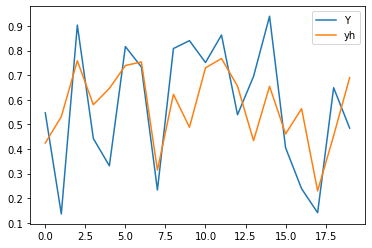

In [630]:
plt.plot(Y)
plt.plot(yhs[np.argmin(errs)][0])
#plt.plot(yhs[-1][0])
plt.legend(['Y', 'yh'])
plt.show()

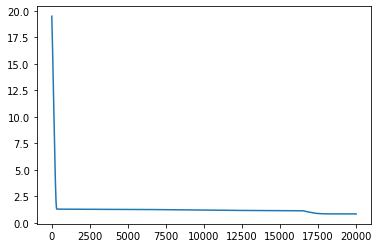

In [631]:
plt.plot(np.array(errs)[:,0])
plt.show()

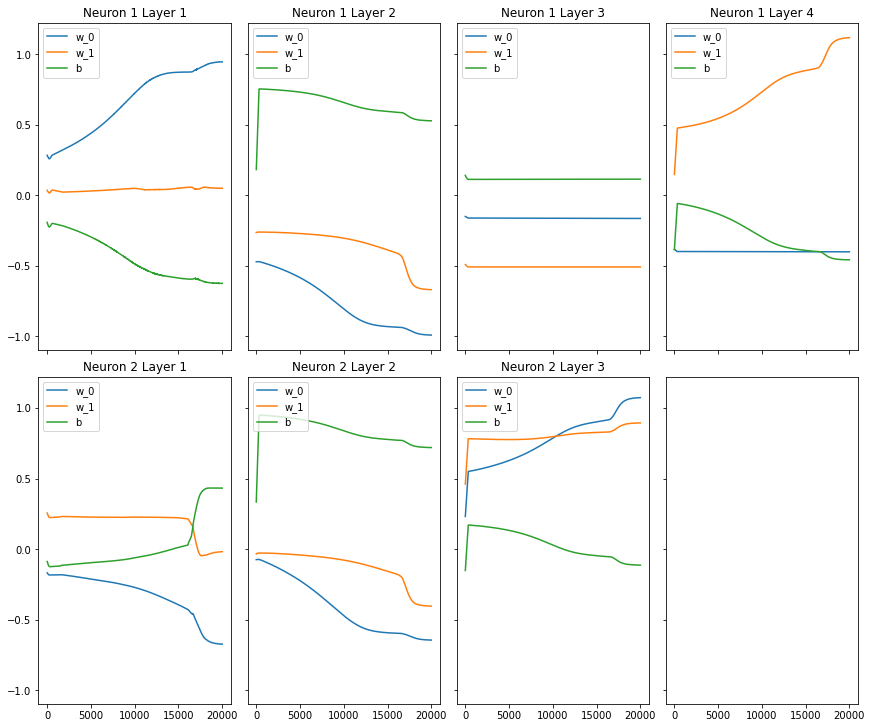

In [632]:
fig, ax = plt.subplots(max([len(layer) for layer in layers]),
                       len(layers),
                       figsize = (3*len(layers), 5*max([len(layer) for layer in layers])),
                       constrained_layout = True,
                       sharey = True,
                       sharex = True)

for k, layer in enumerate(layers):
    for n, neuron in enumerate(layer):
        lgd = []
        shrinkage = int(len(neuron.Ws)/len(errs))
        for w_idx, _ in enumerate(np.array(neuron.Ws)[0,:]):
            ax[n][k].plot(np.array(neuron.Ws)[:,w_idx][0::shrinkage])
            lgd.append(f'w_{w_idx}')
        ax[n][k].plot(np.array(neuron.Bs)[:, 0][0::shrinkage])
        lgd.append('b')
        #ax2 = ax[n][k].twinx()
        #ax2.plot(np.array(errs)[:,0], c = 'black', linestyle = 'dashed')
        #ax2.legend('e', loc = 'upper right')
        ax[n][k].legend(lgd, loc = 'upper left')
        ax[n][k].set_title(f'Neuron {n+1} Layer {k+1}')
    
plt.show()

In [633]:
len(errs[np.argmin(errs):])

31

In [634]:
layers[0][0].Ws[-100:]

[array([[0.9450844 ],
        [0.04939011]]),
 array([[0.94506989],
        [0.04937136]]),
 array([[0.94507877],
        [0.04937947]]),
 array([[0.94511117],
        [0.04941409]]),
 array([[0.94516584],
        [0.04947461]]),
 array([[0.94522723],
        [0.04954262]]),
 array([[0.945266 ],
        [0.0495849]]),
 array([[0.94528156],
        [0.04960048]]),
 array([[0.94527368],
        [0.04958962]]),
 array([[0.94524237],
        [0.04955187]]),
 array([[0.94518855],
        [0.04948844]]),
 array([[0.94515612],
        [0.04944974]]),
 array([[0.94514626],
        [0.04943722]]),
 array([[0.94515906],
        [0.04945049]]),
 array([[0.94519486],
        [0.04949031]]),
 array([[0.94525289],
        [0.04955558]]),
 array([[0.94528938],
        [0.04959599]]),
 array([[0.94530314],
        [0.04961009]]),
 array([[0.94529415],
        [0.04959832]]),
 array([[0.94526206],
        [0.04955992]]),
 array([[0.94520771],
        [0.04949603]]),
 array([[0.94514943],
        [0.049